# Setup

In [ ]:
import math, random, matplotlib.pyplot as plt, operator, torch
from functools import partial
from fastcore.all import *
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor
import numpy as np

In [ ]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [ ]:
def plot_data(centroids:torch.Tensor,# Centroid coordinates
              data:torch.Tensor, # Data Coordinates
              n_samples:int, # Number of samples
              ax:plt.Axes=None # Matplotlib Axes object
             )-> None:
    '''Creates a visualization of centroids and data points for clustering problems'''
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

# Intro

This follows what Jeremy Howard did in a notebook as part of the [2022 part 2 course](https://www.fast.ai/posts/part2-2022.html).  I'm changing a few things and explaining things slightly different, but that's the inspiration and starting point!  K-Means is a more well known clustering approach than meanshift, but meanshift is newer and is advantageous in a lot of situations.

First, you don't have to decide how many clusters ahead of time.  This is important because in many datasets especially as they get very complex it can be hard to know how many clusters you really should have.  Meanshift requires bandwidth which is much easier to select.

Second, k-means looks at circular clusters.  You need to do some custom work to make it work for non-circular clusters.  Sometimes data doesn't split nicely into circular clusters.  Meanshift handles clusters of any shape.

# Generate Dataset

I'm doing the same thing Jeremy did as the same dataset can be used, I used his approach and refactored is as I plan to re-use it later on for larger experiments.

In [ ]:
def create_dataset(n_clusters,n_samples):
    centroids = torch.rand(n_clusters, 2)*70-35 # Points between -35 and 35
    def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))
    data = torch.cat([sample(c) for c in centroids])
    return data,centroids

In [ ]:
n_clusters = 6
n_samples = 250
data,centroids = create_dataset(n_clusters,n_samples)

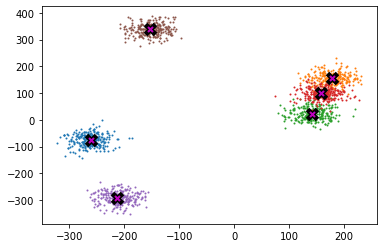

In [ ]:
plot_data(centroids, data, n_samples)

# Meanshift

MeanShift is a clustering algorithm.  There's 3 main steps to the process:

    + Calculate distances between every point
    + Calculate weights based on distance and bandwidth
    + Update centroid predictions using weights and distances to calculate weighted average

Once you have those steps, you can repeat these until you have your final centroid locations

## Calculate Distance

In K-Means, you calculate the distance between each point and the cluster centroids.  In meanshift we calculate the distance between each point and every other point.

Given a tensor of centroid coordinates and a tensor of data coordinates we calculate distance by:
+ Subtract data points coordinates from all other data point coordinates
+ Take absolute value of distances
+ Pythagorean Calculation
    + Square coordinates
    + Add them together
    + Take the Square Root
    
That gives us the euclidean distance between each data point.

In [ ]:
def calculate_distances(data:torch.Tensor # Data points you want to cluster
                       )-> torch.Tensor: # Tensor containing euclidean distance between each centroid and data point    
    '''Calculate distance between centroids and each datapoint'''
    axis_distances = data.reshape(-1,1,2).sub(data.reshape(1,-1,2)).abs()
    euclid_distances = axis_distances.square().sum(axis=-1).sqrt()
    return euclid_distances

## Calculate weights

Next we need to create the weights.  There are 2 factors that go into calculating weights

+ How far away is this point from the other point?
+ What's the bandwidth?

The way we use this is we create a gaussian function to determine the weight based on distance.  That looks like this.

In [ ]:
def gaussian(x): return torch.exp(-0.5*((x))**2) / (math.sqrt(2*math.pi))

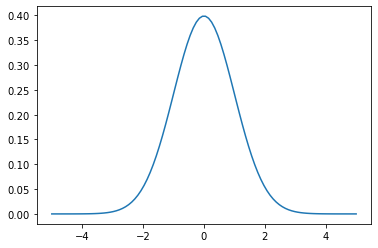

In [ ]:
_x=torch.linspace(-5, 5, 100)
plt.plot(_x,gaussian(_x)); plt.show()

We modify the above slightly by adding a parameter called the bandwidth.  By adjusting the bandwidth we can adjust how fast or slow the weights decay as the distance increases.  A Gaussian with a bandwidth of 1 (middle chart) is just the normal distribution we saw above.  

Because distance is never negative, we don't need negative values

:::{.callout-tip}
The bandwidth is the standard deviation of the gaussian
:::

In [ ]:
def gaussian(x, bw): return torch.exp(-0.5*((x/bw))**2) / (bw*math.sqrt(2*torch.pi))

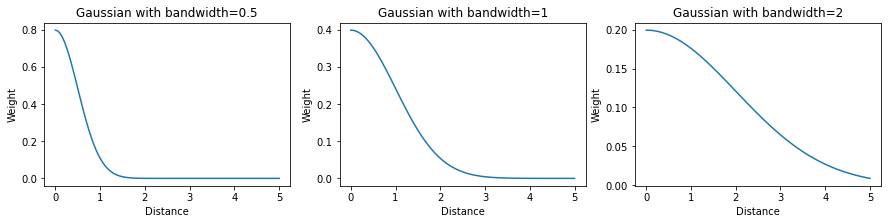

In [ ]:
_x=torch.linspace(0, 5, 100)
fig,ax = plt.subplots(1,3,figsize=(15,3))
for a,bw in zip(ax,[.5,1,2]):
    a.plot(_x, gaussian(_x, bw))
    a.set_title(f"Gaussian with bandwidth={bw}")
    a.set_xlabel('Distance'); a.set_ylabel('Weight')
plt.show()

## Update Centroids

Now that we have our distance and weights we can update our centroid predictions and loop through until the points converge to give us cluster locations.  We do this by taking a weighted average of all the other points based (using the weights calculated previously).

:::{.callout-note}
I am calling it `meanshift1` because we will be iterating on it later to speed the algorithm up.
:::


In [ ]:
def meanshift1(X):
    dist = calculate_distances(X)
    weight = gaussian(dist, 2.5)
    X = weight@X/weight.sum(1,keepdim=True)

## All Together

Now that we have our meanshift function, we can create a function to run the model for several epochs and plot it.

In [ ]:
def run_exp(data,fn,max_epochs=100,cuda=False):
    coord = data.clone()
    if cuda: coord = coord.cuda()
    for i in range(max_epochs):
        coord = fn(coord)
        p_centroids = torch.unique(coord,dim=0)
        if len(p_centroids) == 6: break
    return p_centroids,coord,i

In [ ]:
def plot_results(centroids:torch.Tensor,# Centroid coordinates
              p_centroids:torch.Tensor, # Data Coordinates
              ax:plt.Axes=None # Matplotlib Axes object
             )-> None:
    '''Creates a visualization of centroids and data points for clustering problems'''
    if ax is None: _,ax = plt.subplots()
    ax.scatter(p_centroids[:,0],p_centroids[:,1],label='Predicted',marker='x',s=200)
    ax.scatter(centroids[:,0],centroids[:,1],label='Target',marker='o',s=200,alpha=0.5)
    ax.legend()
    plt.show()

# Experiments

In [ ]:
n_clusters = 6
n_samples = 250
data,centroids = create_dataset(n_clusters,n_samples)

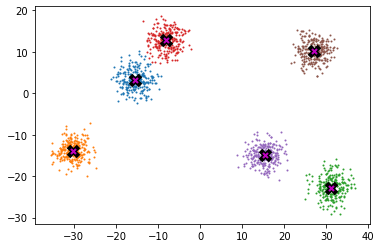

In [ ]:
plot_data(centroids, data, n_samples)

## Baseline

In [ ]:
def meanshift1(X):
    dist = calculate_distances(X)
    weight = gaussian(dist, 2.5)
    return weight@X/weight.sum(1,keepdim=True)

In [ ]:
cuda=False
fn=meanshift1
%timeit p_centroids,p_coord,p_epochs = run_exp(data,fn)
p_centroids,p_coord,p_epochs = run_exp(data,fn)
p_centroids.shape

127 ms ± 443 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


torch.Size([6, 2])

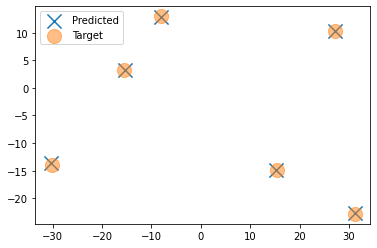

In [ ]:
plot_results(centroids,p_centroids)

## Ramp

In [ ]:
def tri(d, i): return (-d+i).clamp_min(0)/i

In [ ]:
def meanshift2(X):
    dist = calculate_distances(X)
    weight = tri(dist, 8)
    return weight@X/weight.sum(1,keepdim=True)

In [ ]:
cuda=False
fn=meanshift2
%timeit p_centroids,p_coord,p_epochs = run_exp(data,fn)
p_centroids,p_coord,p_epochs = run_exp(data,fn)
p_centroids.shape

1.41 s ± 9.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


torch.Size([24, 2])

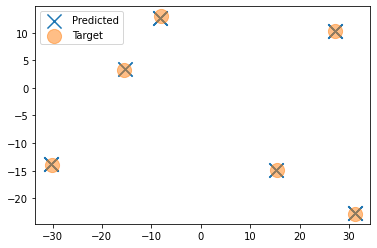

In [ ]:
plot_results(centroids,p_centroids)

## Sampling

In [ ]:
def meanshift3(X):
    X = X[np.random.choice(len(X),150)]
    dist = calculate_distances(X)
    weight = tri(dist, 6)
    return weight@X/weight.sum(1,keepdim=True)

In [ ]:
cuda=False
fn=meanshift3
%timeit p_centroids,p_coord,p_epochs = run_exp(data,fn)
p_centroids,p_coord,p_epochs = run_exp(data,fn)
p_centroids.shape

22.5 ms ± 3.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


torch.Size([6, 2])

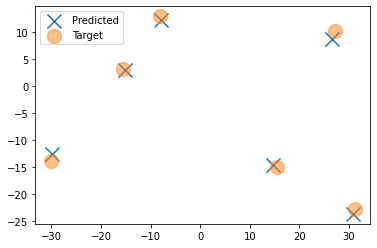

In [ ]:
plot_results(centroids,p_centroids)

## Ball Tree

## KD Tree

In [ ]:
from scipy import spatial

In [ ]:
import scipy.spatial
def meanshift4(X):
    # X = X[np.random.choice(len(X),50)]
    _dist,idxs = scipy.spatial.KDTree(X).query(X,100)
    _dist = torch.Tensor(_dist)
    dist = torch.zeros(len(X),len(X))

    for i,idx in enumerate(idxs): dist[i][idx] = _dist[i]
    
    weight = tri(dist, 6)
    return (weight@X/weight.sum(1,keepdim=True))

In [ ]:
cuda=False
fn=meanshift4
%timeit p_centroids,p_coord,p_epochs = run_exp(data,fn)
p_centroids,p_coord,p_epochs = run_exp(data,fn)
p_centroids.shape

2.65 s ± 4.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


torch.Size([1, 2])

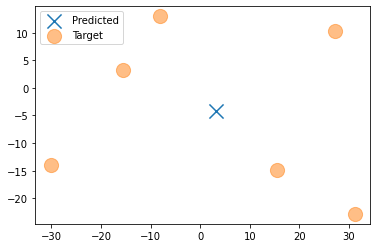

In [ ]:
plot_results(centroids,p_centroids)

## OCTree

## Locality Sensitive Hash